# Class room Exercise Searching for Water signal in GRACE Level 3 Products 
**Part of applied Groundwater modelling** Roelof Rietbroek, April 2022
<img src="images/water-cycle2.png" alt="The Earth's water cycle" style="width: 900px;"/>
<small>Source: JPL/Caltech</small>

# Introduction
This jupyter exercise is meant to give you a better idea of the following:

1. Get to know jupyter notebooks and a bit of python
2. Of the information content of GRACE (Level 3 products)


# Where to get help
* [Python Data-Science-Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) 
* [Tellus grace site](https://grace.jpl.nasa.gov)
* [Gravis GFZ site](http://gravis.gfz-potsdam.de/home)

# Getting started
* I assume you're running this notebook on the [EOAFRICA innovation lab](https://www.eoafrica-rd.org/) so you don't really need to install anything. You do need internet and a (modern) browser
* Basically, a jupyter instance is remote computing service which you can interactively feed with code (python or other languages, as can be seen above)
* The code and documentation in a jupyter notebook are contained in cells
    * markdown cells (such as this one) in which you can add rich text to document things
    * code cells which contain chunks of (python) code which can be interactively send to the **kernel**. After executing the code, variables defined will stay in memory and possibly output is visualized in your browser 

# Step 1: copy/rename this notebook file to your own home folder
1. Right click on this notebook file in the left pane and select `copy`
2. Navigate to your home folder in the left pane, right click on an empty space and select `paste`

# Step 2 load some python modules which we'll need later

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as mpl
import requests
import zipfile
import os
import fiona

ModuleNotFoundError: No module named 'cartopy'

# Step 3 Load a monthly dataset (CSR processing set)

In [2]:
# Step 2: Getting some data in netcdf format. Or better, opening a netcdf dataset as a remote object
#You can find a collection of data url's for this product here: https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/grace/land_mass/RL06/v04/CSR/
dataurl="https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/grace/land_mass/RL06/v04/CSR/GRD-3_2004061-2004091_GRAC_UTCSR_BA01_0600_LND_v04.nc"
#load the data using xarray
csrdata=xr.open_dataset(dataurl)


In [3]:
# you can inspect an xarray dataset by just entering the variable name and executing the cell 
csrdata

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 180, lon: 360, time: 1)
Coordinates:
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time           (time) datetime64[ns] 2004-03-16T12:00:00
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes: (12/58)
    Conventions:                     CF-1.6
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    title:                           GRACE-FO Water-Equivalent-Thickness Surf...
    id:                              TELND-3NC64
    summary:                         Gridded surface mass anomalies, derived ...
    processing_level:                3
    ...                              ...
    geospatial_lat_resolution:       One degree grid
    geospatial_lon_min:              0.5
    geospatial_lon_max:              359.5
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       One degree grid
    DODS_EXTRA.Unlimited_Dimension:  time

# Step 4 make a quick plot of the data

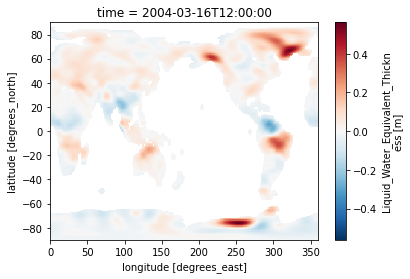

In [23]:
csrdata.lwe_thickness[0,:].plot.imshow()

# Intermediate questions
* Try plotting a different month
* What features which you can see relate to the water cycle?

# Step 5: zoom in a specific region
You can make use of the xarray functionality for selecting a subset of the data

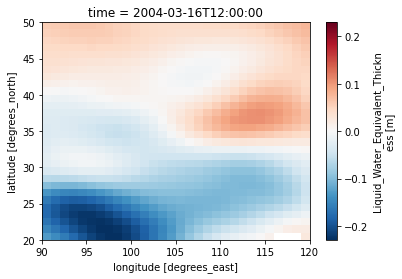

In [31]:
lonmin=90
lonmax=120
# lonmin=220
# lonmax=300

latmin=20
latmax=50

lonselect=(csrdata.lon <= lonmax) & (csrdata.lon >= lonmin)
latselect=(csrdata.lat <= latmax) & (csrdata.lat >= latmin)
csrsub=csrdata.where(lonselect & latselect ,drop=True )


csrsub.lwe_thickness[0,:].plot.imshow()

# The grids will look quite blocky when zoomed in. For more smoother transitions try passing an interpolation option to imshow
[see here for the options](https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html)

# Question
* Try out different areas where you suspect to find interesting hydrological signals

# Step 6 Making better geographical plots with [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

The function `imshow` of xarray is internally linked [to the matplotlib function imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow). We can however pass a so-called plotting axes-system explicitly. We can make use of this to construct a plotting axis with cartopy which uses specific [geographical projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)


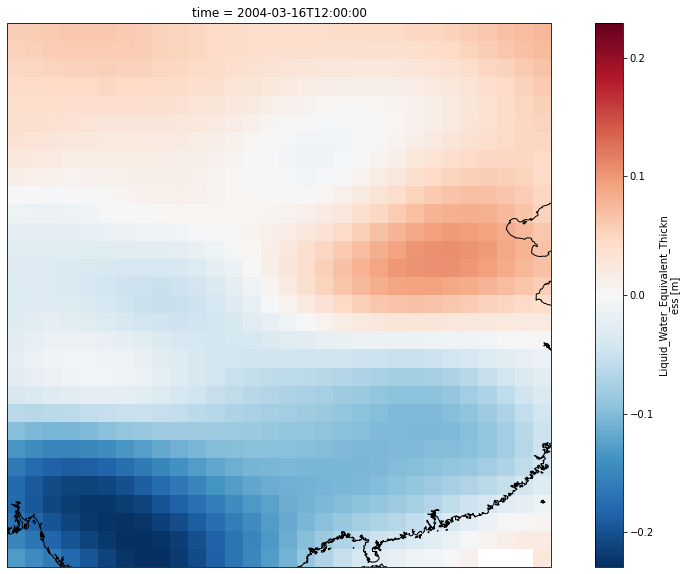

In [33]:
mpl.figure(figsize=(16,10))
crs=ccrs.PlateCarree()
ax = mpl.subplot(projection=crs)
csrsub.lwe_thickness[0,:].plot.imshow(ax=ax)
ax.coastlines(resolution='10m')

# Questions
* Try using better projections for the region of interest
* Try getting a hand on an shapefile of a large aquifer system and try plotting the aquifer system onto the map as well

In [64]:
# Do you know you can download file using python easily. Here's how we do it
usaquiurl="https://water.usgs.gov/GIS/dsdl/aquifers_us.zip"
r=requests.get(usaquiurl)



fout=os.path.basename(usaquiurl)
with open(fout,"wb") as fid:
    fid.write(r.content)

# also extract the content

with zipfile.ZipFile(fout) as zip_ref:
    zip_ref.extractall("aquifers") # extract file to dir

# tar files can be done in a similar way
# with tarfile.open(tgzout) as tar:
#     tar.extractall("aquifers")

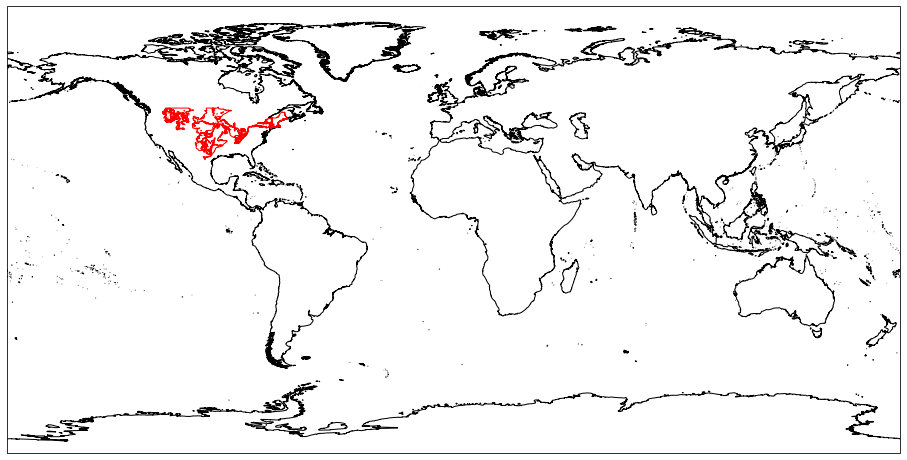

In [54]:
from shapely.geometry import shape
usaqui=fiona.open("aquifers","r")

mpl.figure(figsize=(16,10))
crs=ccrs.PlateCarree()
ax = mpl.subplot(projection=crs)
ax.coastlines(resolution='10m')

for x in usaqui:
    if x["properties"]["Shape_Area"] < 40:
        continue
#     print(x["properties"])
    ax.add_geometries([shape(x["geometry"])],crs=crs,edgeColor='red',faceColor='none',lineWidth=1)
    

# Advanced Questions
* Can you create a time series of the average over a certain region by iterating over multiple input files?
* Can you create an animation of a region including major aquifers overlaid by GRACE equivalent water heights?